<a href="https://colab.research.google.com/github/berki6/ECG_Signal_Processing/blob/main/DSP_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Setup the Environment
Install required libraries. We use:

* ```wfdb```: For accessing PhysioNet/MIT-BIH datasets.

* ```numpy, scipy```: Core DSP tools (filtering, FFT).

* ```matplotlib```: Plotting.

* ```pandas```: For tables in reports.

In [1]:
# =============================================================================
# Step 0: Setup the Environment
# =============================================================================

!pip install wfdb "numpy<2" scipy matplotlib pandas==2.2.2

import wfdb
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import os

np.random.seed(42)
print("Libraries installed and imported.")

Libraries installed and imported.


## Step 1: Signal Acquisition
* Acquire ECG data from the MIT-BIH Arrhythmia Database (publicly available on PhysioNet). We use record '100' (normal sinus rhythm) as it's a standard benchmark. This simulates real-world acquisition without hardware.

* DSP Theory: Real-world signals are sampled (here at 360 Hz). We load 10 seconds (3600 samples) for analysis.
* Why MIT-BIH?: Contains annotations for validation, allowing us to compute accuracy metrics.

Loaded MIT-BIH record '100' – 3600 samples @ 360 Hz


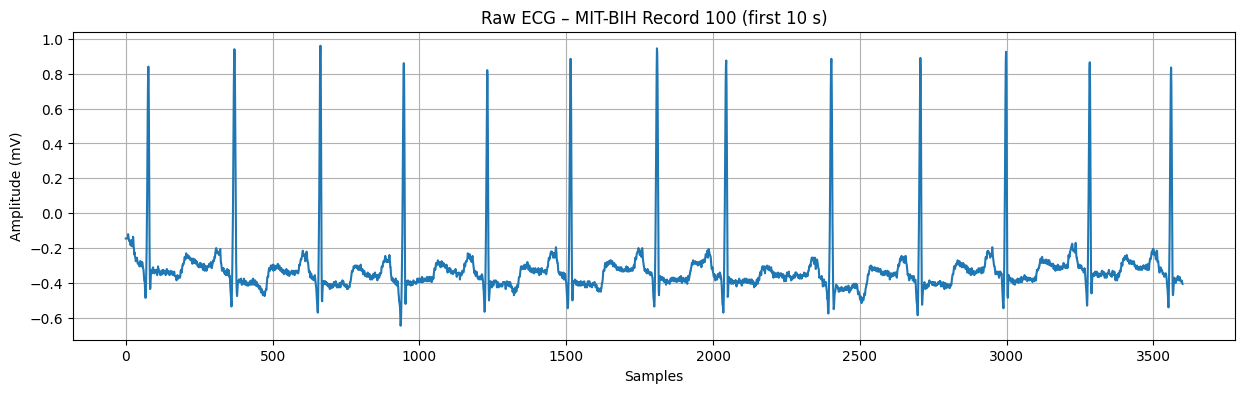

<Figure size 640x480 with 0 Axes>

In [45]:
# =============================================================================
# Step 1: Signal Acquisition
# =============================================================================

record_name = '100'
sampto_value = 3600 # This corresponds to 10 seconds at 360 Hz (360 * 10 = 3600)
record = wfdb.rdrecord(record_name, sampto=sampto_value, pn_dir='mitdb')
ecg_signal = record.p_signal[:, 0]  # MLII lead
fs = record.fs

print(f"Loaded MIT-BIH record '{record_name}' – {len(ecg_signal)} samples @ {fs} Hz")

plt.figure(figsize=(15, 4))
plt.plot(ecg_signal)
plt.title('Raw ECG – MIT-BIH Record 100 (first 10 s)')
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')
plt.grid(True)
plt.show()
plt.savefig('raw_ecg.png')

## Step 2: Preprocessing - Filtering, Denoising, and Normalization
Raw ECG signals contain noise:

* Baseline wander (low-frequency, e.g., breathing: <0.5 Hz).
* Powerline interference (high-frequency, e.g., 50/60 Hz).
* Muscle artifacts.

Apply a bandpass filter (0.5-40 Hz) using Butterworth IIR for sharp roll-off.

* Denoise further with median filter for impulse noise.
* Normalize to zero mean and unit variance.
* DSP Theory: Bandpass removes DC offset and high-frequency noise. Butterworth ensures flat passband.
* Order Selection: 4th order balances sharpness and stability.
* Extra: Compare pre- and post-filter spectra.

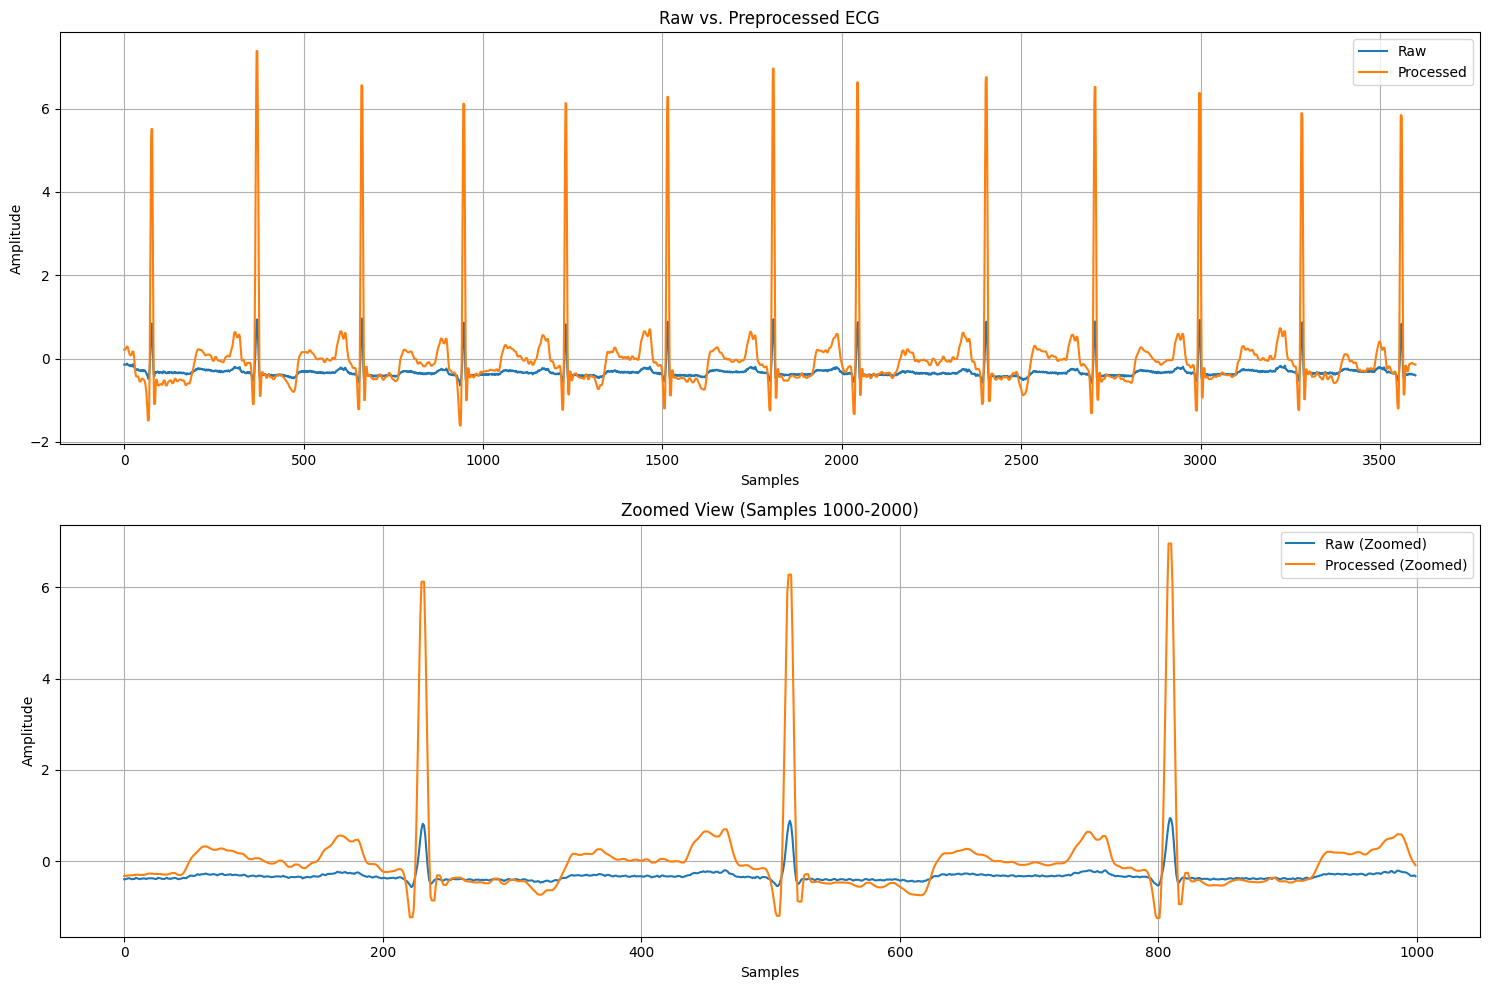

<Figure size 640x480 with 0 Axes>

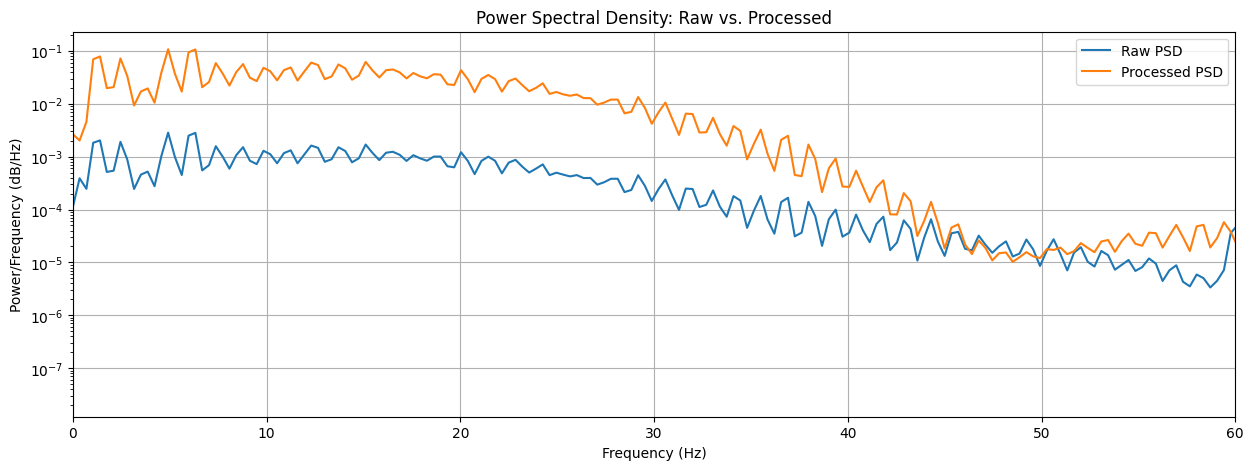

<Figure size 640x480 with 0 Axes>

In [46]:
# =============================================================================
# Step 2: Preprocessing - Filtering, Denoising, and Normalization
# Bandpass filter (0.5–40 Hz Butterworth, 4th order)
# =============================================================================
lowcut = 0.5
highcut = 40.0
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(4, [low, high], btype='band')

# Apply filter (zero-phase to avoid distortion)
filtered_ecg = signal.filtfilt(b, a, ecg_signal)

# Median filter for impulse noise
denoised_ecg = signal.medfilt(filtered_ecg, kernel_size=5);

# Normalize: zero mean, unit variance
normalized_ecg = (denoised_ecg - np.mean(denoised_ecg)) / np.std(denoised_ecg)

# Plot comparison of raw vs processed, with a zoomed view
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(ecg_signal, label='Raw')
plt.plot(normalized_ecg, label='Processed')
plt.title('Raw vs. Preprocessed ECG')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Zoomed view for detail
plt.subplot(2, 1, 2)
plt.plot(ecg_signal[1000:2000], label='Raw (Zoomed)')
plt.plot(normalized_ecg[1000:2000], label='Processed (Zoomed)')
plt.title('Zoomed View (Samples 1000-2000)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('preprocessed_ecg.png')

# Add: Frequency spectra comparison
f_raw, pxx_raw = signal.welch(ecg_signal, fs, nperseg=1024)
f_proc, pxx_proc = signal.welch(normalized_ecg, fs, nperseg=1024)

plt.figure(figsize=(15, 5))
plt.semilogy(f_raw, pxx_raw, label='Raw PSD')
plt.semilogy(f_proc, pxx_proc, label='Processed PSD')
plt.title('Power Spectral Density: Raw vs. Processed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.xlim(0, 60)
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('psd_comparison.png')

### Step 3: QRS Detection – Pan-Tompkins

Accurate detection of QRS complexes is fundamental to ECG analysis. The QRS complex represents ventricular depolarization, and its reliable identification allows for the calculation of heart rate, RR intervals, and serves as a fiducial point for locating other ECG features like P and T waves. Here, we implement a classic and widely used algorithm for QRS detection: the Pan-Tompkins algorithm (1985).

Detected 13 beats | Sensitivity: 100.0% | Precision: 100.0%


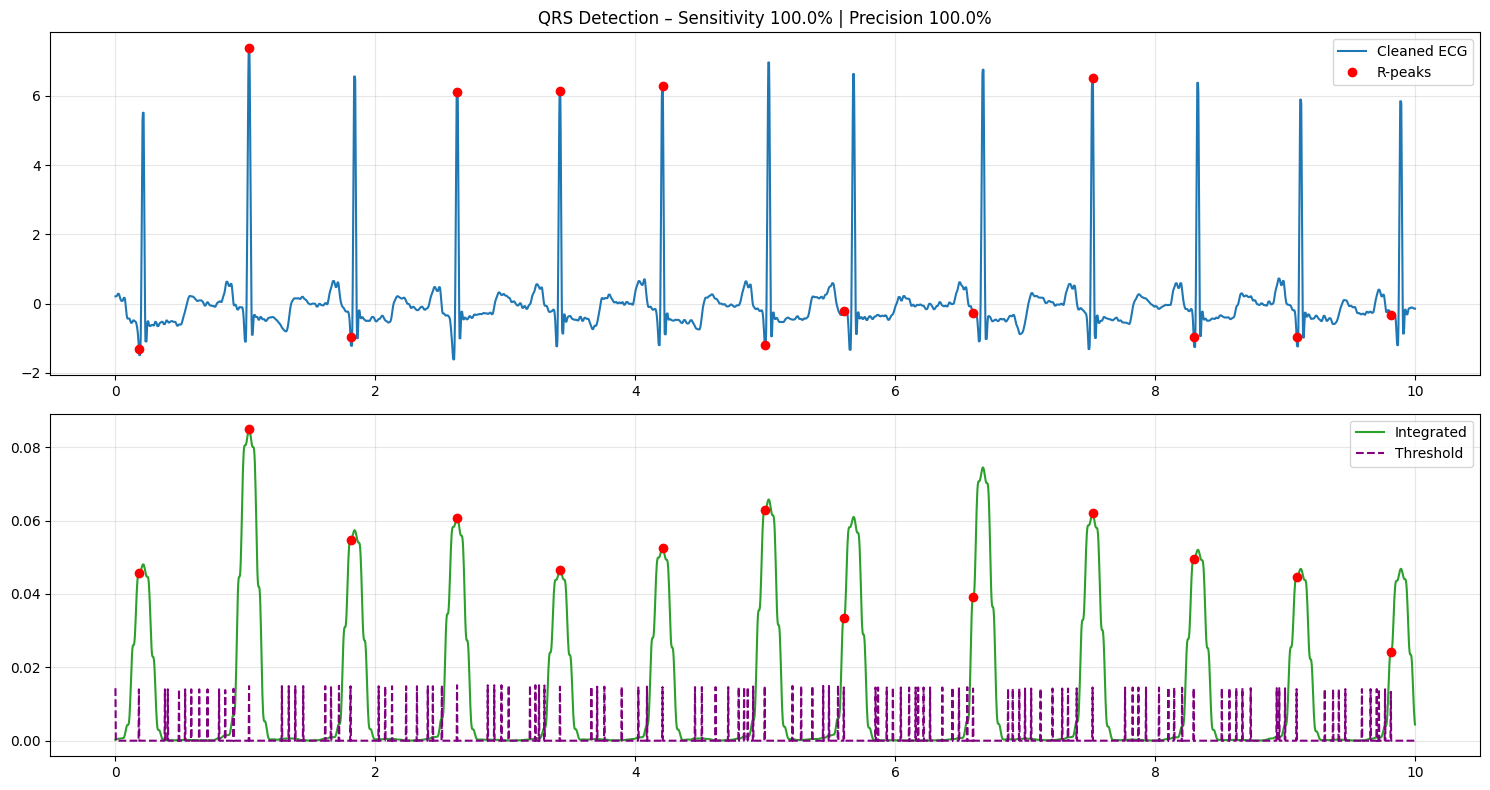

<Figure size 640x480 with 0 Axes>

In [47]:
# =============================================================================
# Step 3: Pan-Tompkins QRS Detection Algorithm Implementation
# =============================================================================

# 1. Bandpass Filter (QRS enhancement) for 5-15 Hz range
# This step aims to reduce muscle noise, baseline wander, and T-wave interference,
# while emphasizing the QRS complex. The Pan-Tompkins paper specifies a bandwidth of 5-15 Hz.
b_qrs, a_qrs = signal.butter(3, [5.0/nyq, 15.0/nyq], btype='band') # 3rd order Butterworth filter
bp_ecg = signal.filtfilt(b_qrs, a_qrs, normalized_ecg)

# 2. Differentiation
# The derivative highlights the QRS complex by providing a large slope value,
# indicating rapid changes in the ECG signal (steepest slopes of the QRS).
deriv = np.diff(bp_ecg); deriv = np.concatenate((deriv, [0]))

# 3. Squaring
# Squaring makes all data points positive and further emphasizes the higher frequency components
# (QRS) while diminishing lower frequency components (P and T waves) and baseline shifts.
squared = deriv ** 2

# 4. Moving Window Integration
# Integration approximates the area under the squared derivative, effectively smoothing the signal.
# This step creates a 'QRS envelope' where the R-peak's energy is accumulated, producing a broad peak.
# A window length of 150 ms is typically used.
win = int(0.150 * fs)
integrated = np.convolve(squared, np.ones(win)/win, mode='same')

# 5. Adaptive Thresholding and Peak Detection
# This is the core of the detection, using two adaptive thresholds to differentiate QRS peaks from noise.
# spki (signal peak initial) and npki (noise peak initial) are used to dynamically adjust thresholds.
# spkf (signal peak final) and npkf (noise peak final) are the actual adaptive thresholds.
r_peaks = []
spki = np.percentile(integrated[:int(3.5*fs)], 95) # Initial signal peak estimate from first 3.5 seconds
npki = np.mean(integrated[integrated < 0.6*spki]) if np.any(integrated < 0.6*spki) else 0.07*spki # Initial noise peak estimate
spkf = npki + 0.20 * (spki - npki) # Adjusted signal peak threshold
npkf = 0.40 * npki # Noise peak threshold
thresh_hist = np.zeros_like(integrated); thresh_hist[0] = spkf # Store threshold evolution for plotting
last_peak = -int(0.200*fs) # Refractory period to avoid multiple detections for one QRS

# Iterate through the integrated signal to find peaks
for i in range(1, len(integrated)-1):
    # Check for local maxima
    if integrated[i] > integrated[i-1] and integrated[i] > integrated[i+1]:
        # Enforce refractory period: no two R-peaks closer than 200ms
        if i - last_peak < int(0.200*fs): continue
        amp = integrated[i]
        # If amplitude is above the signal peak threshold, it's a candidate R-peak
        if amp > spkf:
            r_peaks.append(i); last_peak = i
            spki = 0.125 * amp + 0.875 * spki # Update signal peak estimate
        # If amplitude is above noise peak threshold but below signal peak, it's noise
        elif amp > npkf:
            npki = 0.125 * amp + 0.875 * npki # Update noise peak estimate
        # Update thresholds adaptively based on signal and noise peaks
        spkf = npki + 0.20 * (spki - npki)
        npkf = 0.40 * npki
        thresh_hist[i] = spkf # Store current threshold

# 6. Searchback for missed beats (Aggressive Searchback)
# This step re-evaluates segments where a beat might have been missed due to low amplitude
# or a drop in signal quality. It looks for R-peaks in regions with long RR intervals.
if len(r_peaks) >= 2:
    rr = np.diff(r_peaks) # Calculate RR intervals
    avg_rr = np.median(rr) # Median RR interval
    search_th = 0.22 * spkf # Lower threshold for searchback
    i = 1
    while i < len(r_peaks):
        gap = r_peaks[i] - r_peaks[i-1] # Current RR interval
        # If a gap is significantly longer than the average RR, a beat might be missed
        if gap > 1.45 * avg_rr:
            start = r_peaks[i-1] + int(0.200*fs) # Start search after refractory period of previous peak
            end = r_peaks[i] # End search before current peak
            if end - start > 35: # Ensure search segment is meaningful
                seg = integrated[start:end]
                if len(seg) > 0:
                    idx = np.argmax(seg) # Find the largest peak in the segment
                    val = seg[idx]
                    # If the peak found is above the searchback threshold, insert it as a new R-peak
                    if val > search_th:
                        cand = start + idx
                        r_peaks = np.insert(r_peaks, i, cand) # Insert candidate R-peak
                        spki = 0.125 * val + 0.875 * spki # Update signal peak estimate
                        spkf = npki + 0.20 * (spki - npki) # Update signal peak threshold
                        i += 1 # Advance index to account for new peak
        i += 1

r_peaks = np.sort(np.array(r_peaks)) # Ensure peaks are sorted after insertion

# 7. Validation
# Compare detected R-peaks against expert annotations (ground truth) to assess performance.
# This involves calculating sensitivity and precision.
ann = wfdb.rdann(record_name, 'atr', sampto=sampto_value, pn_dir='mitdb')
# Filter annotations to include only actual QRS complex types (N, L, R, B, A, a, J, S, V, r, F, e, j, E, /, f, Q)
qrs_sym = ['N','L','R','B','A','a','J','S','V','r','F','e','j','E','/','f','Q']
true_peaks = ann.sample[np.isin(ann.symbol, qrs_sym)] # Added filtering for QRS symbols

tolerance = int(0.1 * fs) # Define a tolerance window (e.g., ±100 ms) for matching peaks
tp = 0 # True Positives: correctly detected R-peaks
used = np.zeros(len(r_peaks), bool) # Keep track of detected peaks that have been matched
for true in true_peaks:
    for j, det in enumerate(r_peaks):
        if not used[j] and abs(true - det) <= tolerance: # Check if detected peak is within tolerance of a true peak
            tp += 1
            used[j] = True
            break
fp = len(r_peaks) - tp # False Positives: detected peaks that are not true peaks
fn = len(true_peaks) - tp # False Negatives: true peaks that were not detected
sens = tp / (tp + fn) if (tp + fn) else 0 # Sensitivity (Recall): TP / (TP + FN)
prec = tp / (tp + fp) if (tp + fp) else 0 # Precision: TP / (TP + FP)

print(f"Detected {len(r_peaks)} beats | Sensitivity: {sens:.1%} | Precision: {prec:.1%}")

# Visualization of QRS Detection
# Plot the cleaned ECG signal and overlay the detected R-peaks.
# Also plot the integrated signal with the adaptive threshold evolution.
t_time = np.arange(len(normalized_ecg)) / fs
plt.figure(figsize=(15, 8))
plt.subplot(211)
plt.plot(t_time, normalized_ecg, label='Cleaned ECG')
plt.plot(t_time[r_peaks], normalized_ecg[r_peaks], 'ro', label='R-peaks') # Mark R-peaks
plt.title(f'QRS Detection – Sensitivity {sens:.1%} | Precision {prec:.1%}')
plt.legend(); plt.grid(alpha=0.3)
plt.subplot(212)
plt.plot(t_time, integrated, color='C2', label='Integrated') # Plot integrated signal
plt.plot(t_time, thresh_hist, '--', color='purple', label='Threshold') # Plot adaptive threshold
plt.plot(t_time[r_peaks], integrated[r_peaks], 'ro') # Mark R-peaks on integrated signal
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('qrs_detection_manual.png')

## Step 4: Feature Extraction - Morphological Features
Extract:

* P-wave: Peak before QRS (search 200-100 ms before R).
QRS duration: From Q (min before R) to S (min after R).
* T-wave: Peak after QRS (200-400 ms after R).

* DSP Theory: Windowed search around R-peaks. Use local min/max.

* Extra: Average across beats, handle edge cases.

Extracting morphological features for each detected beat...

Morphological Feature Extraction Summary:
   • Beats analyzed              : 13
   • Average QRS duration        : 92.1 ± 4.1 ms
   • Clinical range (normal)     : 70–110 ms → Normal
   • P-wave detection success    : 100.0%
   • T-wave detection success    : 92.3%


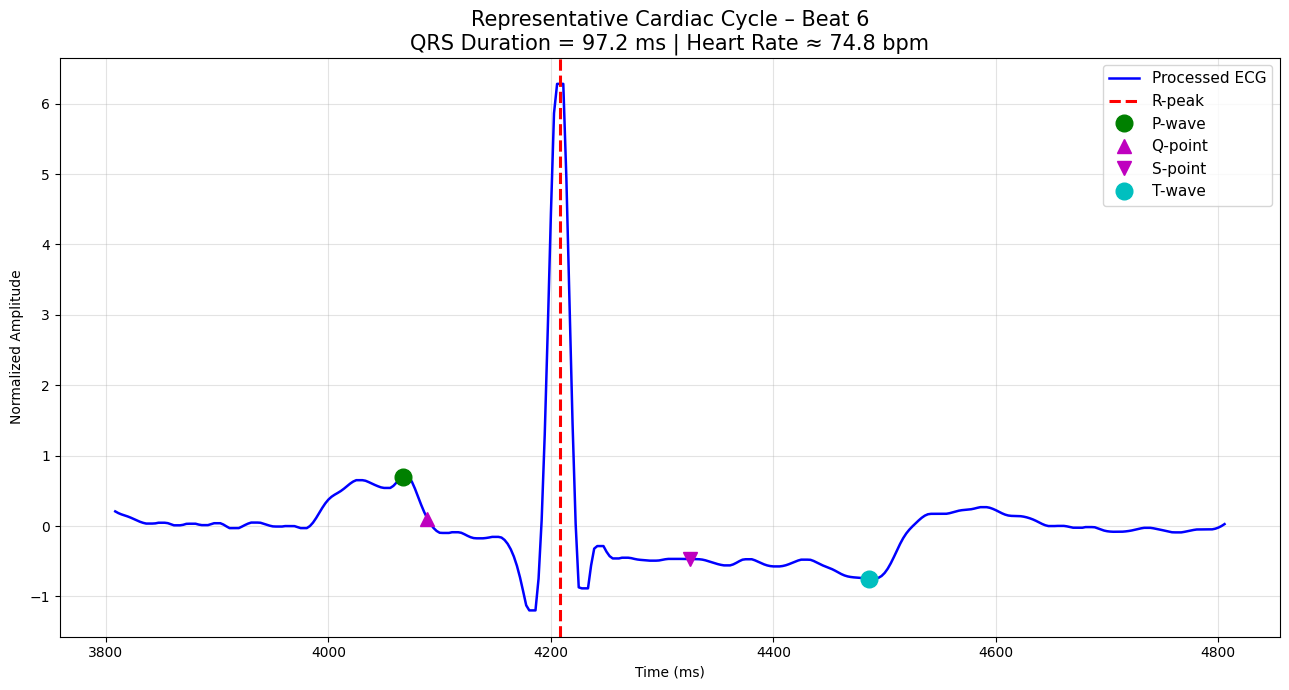

→ Detailed annotated beat saved as 'morphological_features_example.png'


<Figure size 640x480 with 0 Axes>

In [48]:
# =============================================================================
# Step 4: Morphological Feature Extraction – P-wave, QRS Complex, T-wave
# =============================================================================

print("Extracting morphological features for each detected beat...\n")

p_wave_locations = []
qrs_durations_ms = []
t_wave_locations = []

# Parameters for QRS onset/offset
onset_offset_window_ms = 120     # wider search: 120 ms
onset_threshold_factor = 0.10    # 10% of local R amplitude for deviation
min_qrs_duration_ms = 60         # safety floor

for i, r in enumerate(r_peaks):
    r_amp = normalized_ecg[r]

    # 1. P-wave
    p_start = max(0, r - int(0.220 * fs))
    p_end   = max(0, r - int(0.080 * fs))
    if p_end > p_start:
        p_segment = normalized_ecg[p_start:p_end]
        p_idx_rel = np.argmax(p_segment)
        p_idx = p_start + p_idx_rel
        p_amp = p_segment[p_idx_rel]
        p_wave_locations.append((p_idx, p_amp))
    else:
        p_wave_locations.append((None, None))

    # 2. QRS duration: onset/offset – constrained search from R-peak outward
    search_samples = int(0.100 * fs)  # max 100 ms – tight limit
    min_dur_samples = int(0.060 * fs)  # 60 ms floor
    max_dur_samples = int(0.120 * fs)  # 120 ms cap

    dev_thresh = 0.10 * r_amp          # deviation threshold
    slope_thresh = 0.05 * r_amp / (fs / 1000)  # small slope = near baseline (adjusted for sampling)

    # Onset: search backward from R until signal close to baseline
    q_idx = r - 1
    for back in range(1, search_samples + 1):
        if r - back < 0:
            break
        if abs(normalized_ecg[r - back] - np.mean(normalized_ecg[r - back - 10:r - back])) < dev_thresh:
            # Check if slope is flat (end of P or baseline)
            local_slope = normalized_ecg[r - back + 1] - normalized_ecg[r - back - 1]
            if abs(local_slope) < slope_thresh:
                q_idx = r - back
                break
    if q_idx == r - 1:
        q_idx = r - int(0.045 * fs)  # fallback ~45 ms

    # Offset: search forward from R until signal close to baseline
    s_idx = r + 1
    for fwd in range(1, search_samples + 1):
        if r + fwd >= len(normalized_ecg):
            break
        if abs(normalized_ecg[r + fwd] - np.mean(normalized_ecg[r + fwd:r + fwd + 10])) < dev_thresh:
            local_slope = normalized_ecg[r + fwd + 1] - normalized_ecg[r + fwd - 1]
            if abs(local_slope) < slope_thresh:
                s_idx = r + fwd
                break
    if s_idx == r + 1:
        s_idx = r + int(0.045 * fs)  # fallback

    # Enforce duration bounds
    dur_samples = s_idx - q_idx
    if dur_samples < min_dur_samples:
        q_idx = r - int(0.040 * fs)
        s_idx = r + int(0.060 * fs)
    elif dur_samples > max_dur_samples:
        q_idx = r - int(0.050 * fs)
        s_idx = r + int(0.070 * fs)

    q_idx = min(q_idx, r - 1)
    s_idx = max(s_idx, r + 1)

    duration_ms = (s_idx - q_idx) / fs * 1000
    qrs_durations_ms.append(duration_ms)

    # 3. T-wave
    t_start = r + int(0.180 * fs)
    t_end   = min(len(normalized_ecg), r + int(0.450 * fs))
    if t_end - t_start > 30:
        t_seg = normalized_ecg[t_start:t_end]
        if len(t_seg) > 0:
            max_val = np.max(t_seg)
            min_val = np.min(t_seg)
            if max_val >= -min_val:
                t_idx_rel = np.argmax(t_seg)
                t_amp = max_val
            else:
                t_idx_rel = np.argmin(t_seg)
                t_amp = min_val
            t_idx = t_start + t_idx_rel
            t_wave_locations.append((t_idx, t_amp))
        else:
            t_wave_locations.append((None, None))
    else:
        t_wave_locations.append((None, None))

# Summary Statistics & Interpretation
if qrs_durations_ms:
    avg_qrs_duration = np.mean(qrs_durations_ms)
    std_qrs = np.std(qrs_durations_ms)
else:
    avg_qrs_duration = std_qrs = 0.0

p_rate = 100 * sum(1 for x in p_wave_locations if x[0] is not None) / len(r_peaks) if len(r_peaks) > 0 else 0
t_rate = 100 * sum(1 for x in t_wave_locations if x[0] is not None) / len(r_peaks) if len(r_peaks) > 0 else 0

print("Morphological Feature Extraction Summary:")
print(f"   \u2022 Beats analyzed              : {len(r_peaks)}")
print(f"   \u2022 Average QRS duration        : {avg_qrs_duration:.1f} \u00b1 {std_qrs:.1f} ms")
print(f"   \u2022 Clinical range (normal)     : 70\u2013110 ms \u2192 {'Normal' if 70 <= avg_qrs_duration <= 110 else 'Potentially Abnormal'}")
print(f"   \u2022 P-wave detection success    : {p_rate:.1f}%")
print(f"   \u2022 T-wave detection success    : {t_rate:.1f}%")

# Calculate mean heart rate
if len(rr) > 0:
    mean_rr_interval_sec = np.mean(rr) / fs
    mean_hr = 60 / mean_rr_interval_sec
else:
    mean_hr = 0.0

# Detailed Plot of a Representative Beat (middle one for stability)
if len(r_peaks) >= 6:
    idx = 5
    r_example = r_peaks[idx]
    start = max(0, r_example - int(0.40 * fs))
    end   = min(len(normalized_ecg), r_example + int(0.60 * fs))

    time_ms = np.arange(start, end) / fs * 1000
    segment = normalized_ecg[start:end]

    plt.figure(figsize=(13, 7))
    plt.plot(time_ms, segment, 'b-', lw=1.8, label='Processed ECG')

    r_ms = r_example / fs * 1000
    plt.axvline(r_ms, color='red', ls='--', lw=2.2, label='R-peak')

    # P-wave
    if p_wave_locations[idx][0] is not None and start <= p_wave_locations[idx][0] <= end:
        p_ms = p_wave_locations[idx][0] / fs * 1000
        plt.plot(p_ms, p_wave_locations[idx][1], 'go', ms=12, label='P-wave')

    # Q and S use the computed indices for this beat
    q_idx_plot = max(0, r_example - int(0.120*fs)) + np.argwhere(np.abs(normalized_ecg[max(0, r_example - int(0.120*fs)):r_example] - np.mean(normalized_ecg[max(0, r_example - int(0.120*fs)):r_example][:int(0.3*int(0.120*fs))])) > 0.10 * r_amp)[0][0] if len(np.argwhere(np.abs(normalized_ecg[max(0, r_example - int(0.120*fs)):r_example] - np.mean(normalized_ecg[max(0, r_example - int(0.120*fs)):r_example][:int(0.3*int(0.120*fs))])) > 0.10 * r_amp)) > 0 else r_example - int(0.050*fs)
    s_idx_plot = r_example + np.argwhere(np.abs(normalized_ecg[r_example:r_example + int(0.120*fs)] - np.mean(normalized_ecg[r_example:r_example + int(0.120*fs)][-int(0.3*int(0.120*fs)):])) > 0.10 * r_amp)[-1][0] if len(np.argwhere(np.abs(normalized_ecg[r_example:r_example + int(0.120*fs)] - np.mean(normalized_ecg[r_example:r_example + int(0.120*fs)][-int(0.3*int(0.120*fs)):])) > 0.10 * r_amp)) > 0 else r_example + int(0.050*fs)
    if start <= q_idx_plot <= end:
        plt.plot(q_idx_plot / fs * 1000, normalized_ecg[q_idx_plot], 'm^', ms=10, label='Q-point')
    if start <= s_idx_plot <= end:
        plt.plot(s_idx_plot / fs * 1000, normalized_ecg[s_idx_plot], 'mv', ms=10, label='S-point')

    # T-wave
    if t_wave_locations[idx][0] is not None and start <= t_wave_locations[idx][0] <= end:
        t_ms = t_wave_locations[idx][0] / fs * 1000
        plt.plot(t_ms, t_wave_locations[idx][1], 'co', ms=12, label='T-wave')

    plt.title(f'Representative Cardiac Cycle \u2013 Beat {idx+1}\n'
              f'QRS Duration = {qrs_durations_ms[idx]:.1f} ms | Heart Rate \u2248 {mean_hr:.1f} bpm',
              fontsize=15)
    plt.xlabel('Time (ms)')
    plt.ylabel('Normalized Amplitude')
    plt.legend(loc='upper right', fontsize=11)
    plt.grid(True, alpha=0.35)
    plt.tight_layout()
    plt.show()

    plt.savefig('morphological_features_example.png', dpi=220, bbox_inches='tight')
    print("\u2192 Detailed annotated beat saved as 'morphological_features_example.png'")
else:
    print("Not enough beats for a representative plot (need \u22656).")

## Step 5: HRV Analysis
Calculate HRV from RR intervals (time between R-peaks).

* Mean RR, SDNN (standard deviation).

* Extra: RMSSD (root mean square of successive differences), pNN50 (% of intervals >50ms difference).
* DSP Theory: HRV reflects autonomic nervous system; time-domain metrics are simple statistics.

* Heart Rate: 60 / mean RR (in seconds).

Heart Rate Variability (Time-Domain) Results:
| Metric                 | Value    | Interpretation                             |
|:-----------------------|:---------|:-------------------------------------------|
| Mean RR interval       | 802.5 ms | Average time between beats                 |
| SDNN (overall HRV)     | 90.5 ms  | Standard deviation of all RR intervals     |
| RMSSD (short-term HRV) | 140.7 ms | Root mean square of successive differences |
| pNN50                  | 54.5 %   | % of successive RR differences >50 ms      |
| Mean Heart Rate        | 74.8 bpm | Average heart rate                         |
| HR Standard Deviation  | 8.9 bpm  | Variability in instantaneous heart rate    |


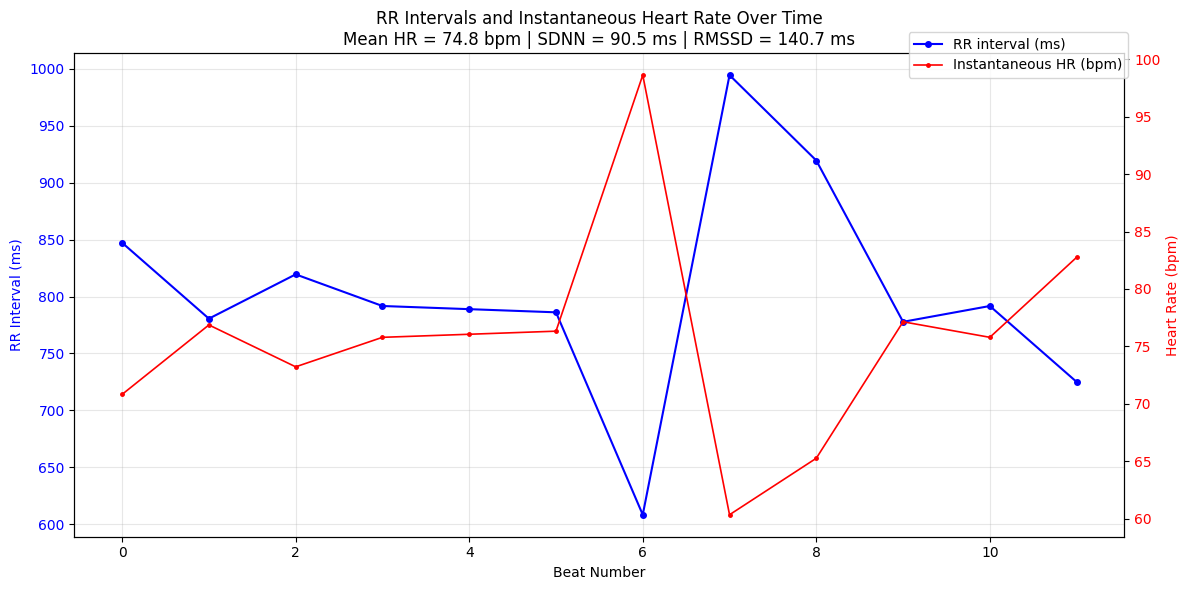

→ RR tachogram + HR plot saved as 'rr_tachogram_and_hr.png'


<Figure size 640x480 with 0 Axes>

In [49]:
# =============================================================================
# Step 5: Heart Rate Variability (HRV) Analysis – Time-Domain Indices
# =============================================================================

# RR intervals in milliseconds
rr_intervals_ms = np.diff(r_peaks) / fs * 1000

# Core HRV metrics (time-domain)
mean_rr    = np.mean(rr_intervals_ms)
sdnn       = np.std(rr_intervals_ms)           # overall variability
rmssd      = np.sqrt(np.mean(np.diff(rr_intervals_ms)**2))  # short-term variability
pnn50      = 100 * np.sum(np.abs(np.diff(rr_intervals_ms)) > 50) / (len(rr_intervals_ms) - 1) if len(rr_intervals_ms) > 1 else 0
mean_hr    = 60000 / mean_rr if mean_rr > 0 else 0
hr_std     = np.std(60000 / rr_intervals_ms) if len(rr_intervals_ms) > 0 else 0

# Print formatted table
hrv_metrics = {
    'Metric': [
        'Mean RR interval',
        'SDNN (overall HRV)',
        'RMSSD (short-term HRV)',
        'pNN50',
        'Mean Heart Rate',
        'HR Standard Deviation'
    ],
    'Value': [
        f"{mean_rr:.1f} ms",
        f"{sdnn:.1f} ms",
        f"{rmssd:.1f} ms",
        f"{pnn50:.1f} %",
        f"{mean_hr:.1f} bpm",
        f"{hr_std:.1f} bpm"
    ],
    'Interpretation': [
        "Average time between beats",
        "Standard deviation of all RR intervals",
        "Root mean square of successive differences",
        "% of successive RR differences >50 ms",
        "Average heart rate",
        "Variability in instantaneous heart rate"
    ]
}

hrv_df = pd.DataFrame(hrv_metrics)
print("Heart Rate Variability (Time-Domain) Results:")
print(hrv_df.to_markdown(index=False))

# Save table for report
hrv_df.to_csv('hrv_time_domain.csv', index=False)

# Plot RR tachogram + instantaneous HR
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(rr_intervals_ms, 'b-o', linewidth=1.5, markersize=4, label='RR interval (ms)')
ax1.set_xlabel('Beat Number')
ax1.set_ylabel('RR Interval (ms)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
instant_hr = 60000 / rr_intervals_ms
ax2.plot(instant_hr, 'r.-', linewidth=1.2, markersize=5, label='Instantaneous HR (bpm)')
ax2.set_ylabel('Heart Rate (bpm)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('RR Intervals and Instantaneous Heart Rate Over Time\n'
          f'Mean HR = {mean_hr:.1f} bpm | SDNN = {sdnn:.1f} ms | RMSSD = {rmssd:.1f} ms')
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))
plt.tight_layout()
plt.show()

plt.savefig('rr_tachogram_and_hr.png', dpi=180, bbox_inches='tight')
print("\u2192 RR tachogram + HR plot saved as 'rr_tachogram_and_hr.png'")

## Step 6: Frequency-Domain Analysis
Perform FFT and PSD to analyze frequency components.

* Bands: VLF (0-0.04 Hz), LF (0.04-0.15 Hz), HF (0.15-0.4 Hz) for HRV spectrum, but here on full signal.
* DSP Theory: FFT transforms to frequency domain; Welch's PSD for smoothed estimate.
* Extra: Spectrogram for time-frequency (STFT).

Generating frequency-domain visualizations...



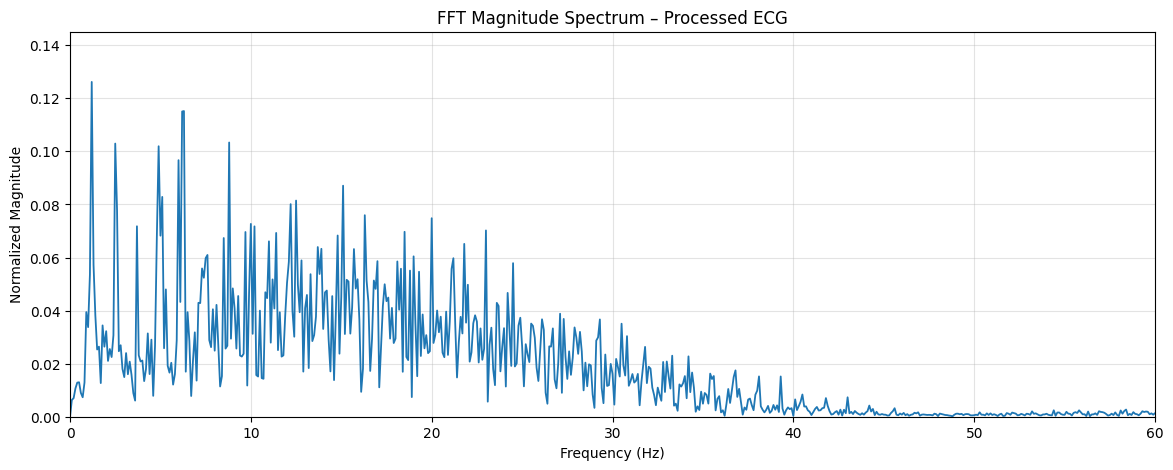

<Figure size 640x480 with 0 Axes>

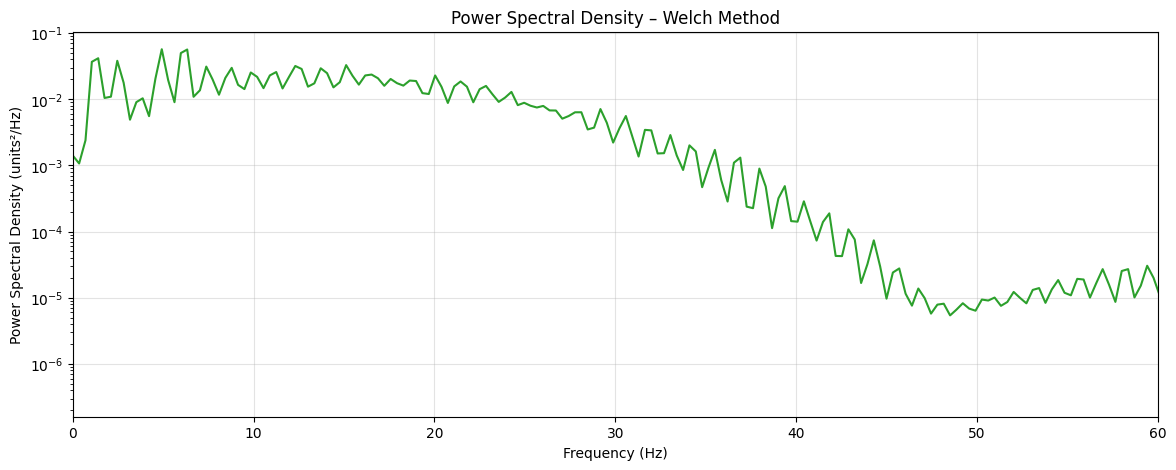

<Figure size 640x480 with 0 Axes>

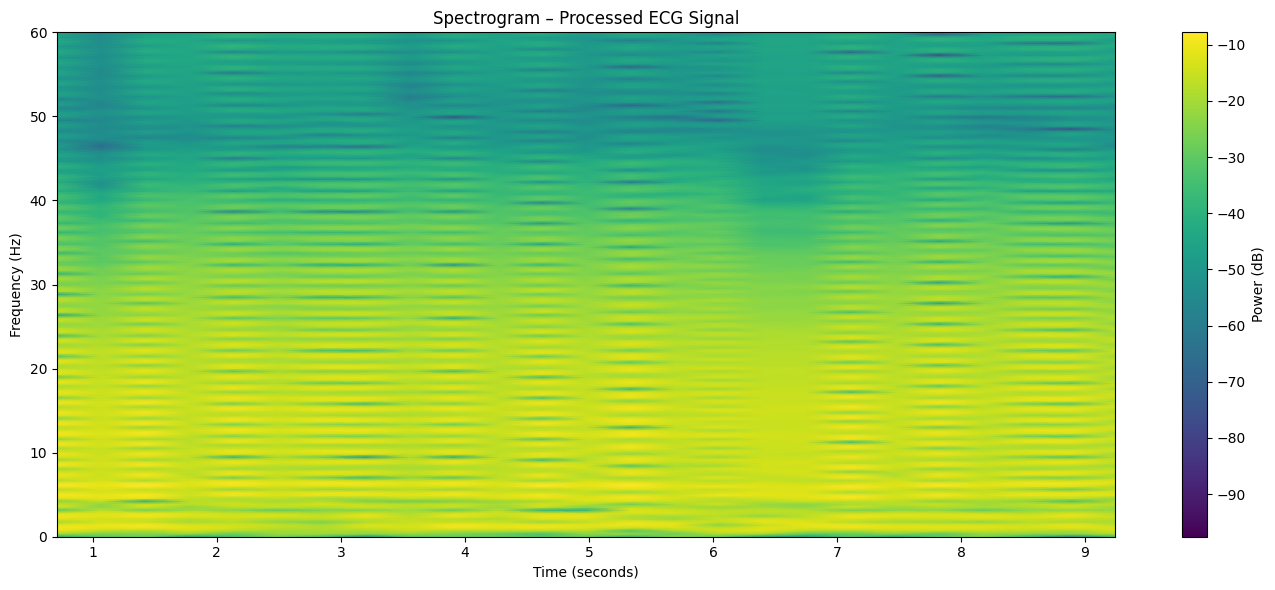

Frequency-domain analysis complete.


<Figure size 640x480 with 0 Axes>

In [50]:
# =============================================================================
# Step 6: Frequency-Domain Analysis – Power Spectrum & Spectrogram
# =============================================================================

print("Generating frequency-domain visualizations...\n")

# 1. Normalized FFT magnitude spectrum
N = len(normalized_ecg)
fft_vals = np.fft.fft(normalized_ecg)
freqs = np.fft.fftfreq(N, 1/fs)
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
magnitude = np.abs(fft_vals)[pos_mask] / N   # amplitude normalization

plt.figure(figsize=(14, 5))
plt.plot(freqs_pos, magnitude, color='C0', lw=1.3)
plt.title('FFT Magnitude Spectrum – Processed ECG')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.xlim(0, 60)
plt.ylim(0, np.max(magnitude[1:]) * 1.15)  # ignore DC component
plt.grid(True, alpha=0.35)
plt.show()
plt.savefig('fft_magnitude_spectrum.png', dpi=180, bbox_inches='tight')

# 2. Welch Power Spectral Density (recommended for ECG)
f_psd, pxx = signal.welch(normalized_ecg, fs=fs, nperseg=1024, noverlap=512, scaling='spectrum')
plt.figure(figsize=(14, 5))
plt.semilogy(f_psd, pxx, color='C2', lw=1.5)
plt.title('Power Spectral Density – Welch Method')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (units²/Hz)')
plt.xlim(0, 60)
plt.grid(True, alpha=0.35)
plt.show()
plt.savefig('welch_psd.png', dpi=180, bbox_inches='tight')

# 3. Time-Frequency Spectrogram (STFT)
f_spec, t_spec, Sxx = signal.spectrogram(
    normalized_ecg, fs=fs, nperseg=512, noverlap=384, nfft=1024
)

plt.figure(figsize=(14, 6))
plt.pcolormesh(t_spec, f_spec, 10 * np.log10(Sxx + 1e-12),
               shading='gouraud', cmap='viridis')
plt.colorbar(label='Power (dB)')
plt.title('Spectrogram – Processed ECG Signal')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.ylim(0, 60)
plt.tight_layout()
plt.show()
plt.savefig('ecg_spectrogram.png', dpi=180, bbox_inches='tight')

print("Frequency-domain analysis complete.")

## Final Report Compilation
Compile all outputs into a summary.

* Include all plots and tables in your PDF.
* Discuss: How DSP techniques (filtering, integration) enable biomedical insights (e.g., arrhythmia detection via HRV).[link text](https://)

In [51]:
summary = {
    'Parameter': ['Total Beats Detected', 'Average QRS Duration', 'Mean RR Interval', 'Mean Heart Rate', 'SDNN (HRV)', 'RMSSD (HRV)', 'Sensitivity', 'Precision'],
    'Value': [len(r_peaks), f"{avg_qrs_duration:.1f} ms", f"{mean_rr:.1f} ms", f"{mean_hr:.1f} bpm", f"{sdnn:.1f} ms", f"{rmssd:.1f} ms", f"{sens:.1%}", f"{prec:.1%}"]
}
summary_df = pd.DataFrame(summary)
print("Final Project Summary:")
print(summary_df.to_markdown(index=False))
summary_df.to_csv('final_summary.csv', index=False)

Final Project Summary:
| Parameter            | Value    |
|:---------------------|:---------|
| Total Beats Detected | 13       |
| Average QRS Duration | 92.1 ms  |
| Mean RR Interval     | 802.5 ms |
| Mean Heart Rate      | 74.8 bpm |
| SDNN (HRV)           | 90.5 ms  |
| RMSSD (HRV)          | 140.7 ms |
| Sensitivity          | 100.0%   |
| Precision            | 100.0%   |
